In [2]:

import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [3]:

df = pd.read_csv('../data/JM1.csv')
df['defects'] = df['defects'].astype(int)


X = df.drop('defects', axis=1)
y = df['defects']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [4]:
# Skapa SMOTE-objekt
smote = SMOTE(random_state=42)

# Skapa syntetiska datapunkter för minoritetsklassen (klass 1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Visa ny fördelning
print("Original y_train-fördelning:\n", y_train.value_counts())
print("\nSMOTE y_train-fördelning:\n", y_train_smote.value_counts())


Original y_train-fördelning:
 defects
0    8881
1    1682
Name: count, dtype: int64

SMOTE y_train-fördelning:
 defects
0    8881
1    8881
Name: count, dtype: int64


C:\Users\josef\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Det går inte att hitta filen
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\josef\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Program Files\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python313\Lib\subprocess.py", line 1036, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~

In [5]:
# Träna Random Forest på balanserad data
rf_smote = RandomForestClassifier(random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# Utvärdera på original testdata
y_pred_smote = rf_smote.predict(X_test)

# Visa resultat
print(confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))


[[2051  169]
 [ 262  159]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90      2220
           1       0.48      0.38      0.42       421

    accuracy                           0.84      2641
   macro avg       0.69      0.65      0.66      2641
weighted avg       0.82      0.84      0.83      2641



In [6]:
from xgboost import XGBClassifier


In [7]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)


y_pred_xgb = xgb_model.predict(X_test)


from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


[[2069  151]
 [ 287  134]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      2220
           1       0.47      0.32      0.38       421

    accuracy                           0.83      2641
   macro avg       0.67      0.63      0.64      2641
weighted avg       0.81      0.83      0.82      2641



C:\Users\josef\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [01:18:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


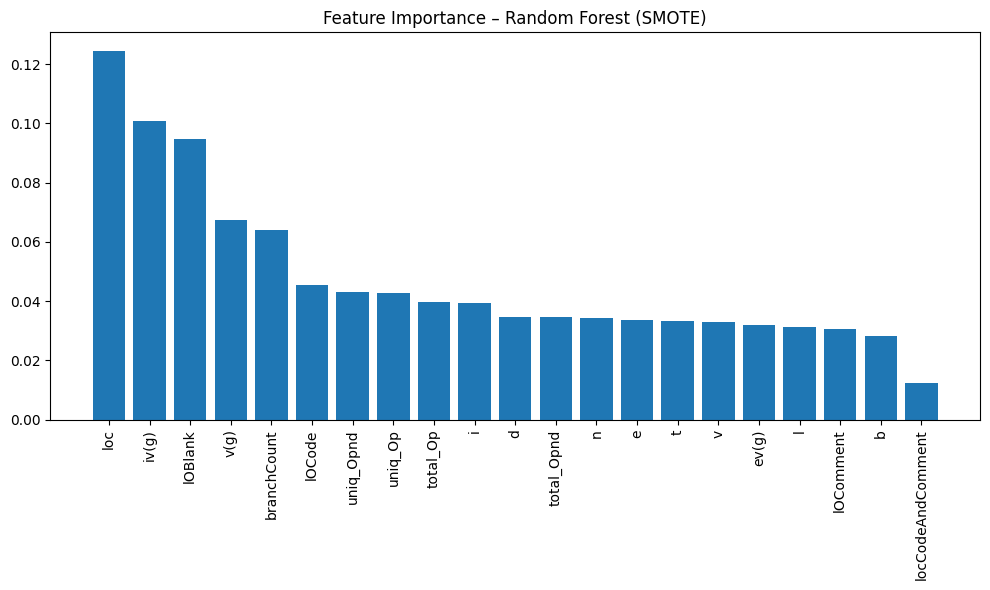

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Lista på feature-namn
feature_names = X.columns.tolist()

# Hämta importance-värden från modellen
importances = rf_smote.feature_importances_

# Sortera och visualisera
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance – Random Forest (SMOTE)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), sorted_features, rotation=90)
plt.tight_layout()
plt.show()
